# Central Line UNet


This noteboook contains all the code neccesary to train and test the UNet used in this project for ultrasound image segmentation.

Note that it assumes [SlicerIGT/aigt](https://github.com/SlicerIGT/aigt) is already cloned locally.

---

## Define user parameters

In [14]:
import numpy as np

#Preprocessing paths
preprocessing_input_dir = r"C:\repos\aigt\DeepLearnLive\Datasets\US_Vessel_Segmentations"
preprocessing_output_dir = r"C:\Users\cbarr\OneDrive - Queen's University\Grad School\Courses\CISC 881\Project\Data\TestData"

#U-Net paths
data_input_dir = r"C:\\Users\\cbarr\\OneDrive - Queen's University\\Grad School\\Courses\\CISC 881\\Project\\Data\\PilotNpData"
aigt_repo_path = r"C:\repos\aigt"
output_dir = r"C:\Users\cbarr\OneDrive - Queen's University\Grad School\Courses\CISC 881\Project\Testing_Folder"

#Notebook name
notebook_name = 'CentralLine_VesselUNet'

#Sequences to be used for validation and testing; the rest is for training
test_idx = [0,1,2,3,4]
current_fold = "fold_1"

# Learning parameters
ultrasound_size = 128                  #Dimensions of the US images used
num_epochs = 5                         #Number of times to adjust weights following use of a batch of data
batch_size = 128                       #Number of images to feed in for each epoch
max_learning_rate = 0.02               #Used in defining Adam parameters
min_learning_rate = 0.00001            #Used to generate learning_rate_decay
regularization_rate = 0.0001           #Used in uNet definition; L1 bias regulation
filter_multiplier = 8                  #used in UNet definition
class_weights = np.array([0.1, 0.9])   #Weights for weighted categorical cross entropy
learning_rate_decay = (max_learning_rate - min_learning_rate) / num_epochs #the rate at which the learning rate decays; adam parameter

# Training data augmentation parameters for segmentation batch generation
max_shift_factor = 0.12
max_rotation_angle = 10
max_zoom_factor = 1.1
min_zoom_factor = 0.8
acceptable_margin_mm = 1.0 #For evaluation of segmentation
mm_per_pixel = 1.0

#Define roc thresholds
roc_thresholds = [0.9, 0.8, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1,
                  0.08, 0.06, 0.04, 0.02, 0.01,
                  0.008, 0.006, 0.004, 0.002, 0.001]

---

## Imports
### Python packages

In [5]:
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import datetime
from sklearn.model_selection import train_test_split
from random import sample
import glob
import cv2
import re
from ipywidgets import IntProgress
from IPython.display import display

### Libraries in aigt repository

In [6]:
sys.path.append(aigt_repo_path)
sys.path.append(os.path.join(aigt_repo_path, "UltrasoundSegmentation"))

import ultrasound_batch_generator as generator
import evaluation_metrics
import Models.segmentation_unet as unet
import utils

## Preprocess data

In [4]:
#Get all sequence names
sequence_names = [name for name in os.listdir(preprocessing_input_dir)]

#Returns the US images resizes to output_size and scaled to their max intensity
def process_us(us_img, output_size):
    resized_img = cv2.resize(us_img, (output_size, output_size)).astype(np.float16)
    return resized_img / resized_img.max()

#Returns the segmentations resized to ultrasound_size
def process_seg(seg_img, output_size):
    return cv2.resize(seg_img, (output_size, output_size)).astype(np.float16)

#Returns a 3D stack of processed US images
def accumulate_and_process(all_img_paths, processing_fxn, output_size, f): 
    data = np.array([], dtype=np.float64).reshape(output_size, output_size, 0)
    for idx, img_path in enumerate(all_img_paths):        #Go through all images in folder
        f.value = idx                                     #Update value of loading bar
        img = cv2.imread(os.path.abspath(img_path), 0)    #Read in an image
        processed_img = processing_fxn(img, output_size)  #Process the image
        data = np.dstack((data, processed_img))           #Add the image to the stack
    return data

#Go through all sequences
for seq in sequence_names:
    
    print("current sequence name: " + seq)
    
    #get all US and segmentation images in the input folders
    us_paths = list(Path(preprocessing_input_dir + "\\" + seq).glob(seq+"_[0-9][0-9][0-9][0-9][0-9].png"))
    seg_paths = list(Path(preprocessing_input_dir + "\\" + seq).glob(seq+"*_segmentation.png"))
    
    #Update loading bars
    f_us = IntProgress(min=0, max=len(us_paths))                    
    print(seq + " Ultrasound Export Progress: ")
    display(f_us)
    f_seg = IntProgress(min=0, max=len(seg_paths)) 
    print(seq + " segmentation Export Progress: ")
    display(f_seg)
                         
    #Accumulate and process images
    us_data = accumulate_and_process(us_paths, process_us, ultrasound_size, f_us)
    seg_data = accumulate_and_process(seg_paths, process_seg, ultrasound_size, f_seg)
    
    #Save the corresponding numpy file
    output_us_path = os.path.join(preprocessing_output_dir, seq +"_ultrasound" )
    output_seg_path = os.path.join(preprocessing_output_dir, seq+"_segmentation" )
    np.save(output_us_path, us_data)
    np.save(output_seg_path, seg_data)

current sequence name: MS01-20200210-132740
MS01-20200210-132740 Ultrasound Export Progress: 


IntProgress(value=0, max=1749)

MS01-20200210-132740 segmentation Export Progress: 


IntProgress(value=0, max=1749)

current sequence name: MS01-20200210-133541
MS01-20200210-133541 Ultrasound Export Progress: 


IntProgress(value=0, max=1123)

MS01-20200210-133541 segmentation Export Progress: 


IntProgress(value=0, max=1123)

current sequence name: MS01-20200210-134522
MS01-20200210-134522 Ultrasound Export Progress: 


IntProgress(value=0, max=1088)

MS01-20200210-134522 segmentation Export Progress: 


IntProgress(value=0, max=1088)

current sequence name: MS01-20200210-135109
MS01-20200210-135109 Ultrasound Export Progress: 


IntProgress(value=0, max=1005)

MS01-20200210-135109 segmentation Export Progress: 


IntProgress(value=0, max=1005)

current sequence name: MS01-20200210-135709
MS01-20200210-135709 Ultrasound Export Progress: 


IntProgress(value=0, max=830)

MS01-20200210-135709 segmentation Export Progress: 


IntProgress(value=0, max=830)

current sequence name: MS02-20200210-152131
MS02-20200210-152131 Ultrasound Export Progress: 


IntProgress(value=0, max=1319)

MS02-20200210-152131 segmentation Export Progress: 


IntProgress(value=0, max=1319)

current sequence name: MS02-20200210-152827
MS02-20200210-152827 Ultrasound Export Progress: 


IntProgress(value=0, max=1059)

MS02-20200210-152827 segmentation Export Progress: 


IntProgress(value=0, max=1059)

current sequence name: MS02-20200210-153709
MS02-20200210-153709 Ultrasound Export Progress: 


IntProgress(value=0, max=979)

MS02-20200210-153709 segmentation Export Progress: 


IntProgress(value=0, max=979)

current sequence name: MS02-20200210-154411
MS02-20200210-154411 Ultrasound Export Progress: 


IntProgress(value=0, max=833)

MS02-20200210-154411 segmentation Export Progress: 


IntProgress(value=0, max=833)

current sequence name: MS02-20200210-160404
MS02-20200210-160404 Ultrasound Export Progress: 


IntProgress(value=0, max=1389)

MS02-20200210-160404 segmentation Export Progress: 


IntProgress(value=0, max=1389)

current sequence name: MS03-20200213-152826
MS03-20200213-152826 Ultrasound Export Progress: 


IntProgress(value=0, max=1218)

MS03-20200213-152826 segmentation Export Progress: 


IntProgress(value=0, max=1218)

current sequence name: MS03-20200213-153647
MS03-20200213-153647 Ultrasound Export Progress: 


IntProgress(value=0, max=1214)

MS03-20200213-153647 segmentation Export Progress: 


IntProgress(value=0, max=1214)

current sequence name: MS03-20200213-154347
MS03-20200213-154347 Ultrasound Export Progress: 


IntProgress(value=0, max=1076)

MS03-20200213-154347 segmentation Export Progress: 


IntProgress(value=0, max=1076)

current sequence name: MS03-20200213-155250
MS03-20200213-155250 Ultrasound Export Progress: 


IntProgress(value=0, max=1256)

MS03-20200213-155250 segmentation Export Progress: 


IntProgress(value=0, max=1256)

current sequence name: MS03-20200213-155823
MS03-20200213-155823 Ultrasound Export Progress: 


IntProgress(value=0, max=663)

MS03-20200213-155823 segmentation Export Progress: 


IntProgress(value=0, max=663)

current sequence name: MS04-20200213-173406
MS04-20200213-173406 Ultrasound Export Progress: 


IntProgress(value=0, max=1663)

MS04-20200213-173406 segmentation Export Progress: 


IntProgress(value=0, max=1663)

current sequence name: MS04-20200213-174259
MS04-20200213-174259 Ultrasound Export Progress: 


IntProgress(value=0, max=1188)

MS04-20200213-174259 segmentation Export Progress: 


IntProgress(value=0, max=1188)

current sequence name: MS04-20200213-175619
MS04-20200213-175619 Ultrasound Export Progress: 


IntProgress(value=0, max=1070)

MS04-20200213-175619 segmentation Export Progress: 


IntProgress(value=0, max=1070)

current sequence name: MS04-20200213-180237
MS04-20200213-180237 Ultrasound Export Progress: 


IntProgress(value=0, max=1120)

MS04-20200213-180237 segmentation Export Progress: 


IntProgress(value=0, max=1120)

current sequence name: MS04-20200213-180907
MS04-20200213-180907 Ultrasound Export Progress: 


IntProgress(value=0, max=1070)

MS04-20200213-180907 segmentation Export Progress: 


IntProgress(value=0, max=1070)

---

## Read in data

In [9]:
#Read the US image and segmentations paths into lists
seg_files = list(sorted(Path(data_input_dir).glob("*_segmentation.npy")))
us_files = list(sorted(Path(data_input_dir).glob("*_ultrasound.npy")))

#Go through all file paths in both arrays and append to list
seg_data_by_seq = []
us_data_by_seq = []
for i in range(len(seg_files)):

    #Load the current files as 3D numpy arrays
    seg_np = np.load(os.path.abspath(seg_files[i]))
    us_np = np.load(os.path.abspath(us_files[i]))
    
    #Normalize and add channel dimension
    seg_np = seg_np[...,np.newaxis] / 255
    us_np = us_np[...,np.newaxis] / 255
    
    #Append to the collector lists.
    seg_data_by_seq.append(seg_np.transpose(2,1,0,3))
    us_data_by_seq.append(us_np.transpose(2,1,0,3))

#Verify that the total number of segmentation images matches the total number of us images.
for idx in range(len(us_data_by_seq)):
    if seg_data_by_seq[idx].shape[0] != us_data_by_seq[idx].shape[0]:
        print("Data Problem: Dataset {} has {} ultrasounds and {} segmentations". format(
            idx, us_data_by_seq[idx].shape[0], len(seg_data_by_seq[idx])))

---

## Divide data into training, validation and testing

In [10]:
#Create lists of indices for training and validation sets
trainAndVal_idx = list(range(len(seg_data_by_seq)))
trainAndVal_idx = [x for x in trainAndVal_idx if x not in test_idx] #Remove IDs

#Extract and concatenate the segmentations for train / test / val
seg_trainAndVal = np.concatenate(np.take(seg_data_by_seq, trainAndVal_idx), axis=0)
seg_test = np.concatenate(np.take(seg_data_by_seq, test_idx), axis=0)

#Extract and concatenate the ultrasound images for train / test / val
us_trainAndVal = np.concatenate(np.take(us_data_by_seq, trainAndVal_idx), axis=0)
us_test = np.concatenate(np.take(us_data_by_seq, test_idx), axis=0)

#Extract training and validation sets from trainAndVal using 80/20 split
us_train, us_val, seg_train, seg_val = train_test_split(us_trainAndVal, seg_trainAndVal, test_size=0.2, random_state=2)

#Convert validation categorical data to onehot dictated by the number of classes
seg_val_onehot = tf.keras.utils.to_categorical(seg_val, 2)
seg_train_onehot = tf.keras.utils.to_categorical(seg_train, 2)
seg_test_onehot = tf.keras.utils.to_categorical(seg_test, 2)

C:\repos\dlenv\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [11]:
print("Trained on {} images, validated on {} images, tested on {} images.".format(us_train.shape[0],
                                                                                 us_val.shape[0],
                                                                                 us_test.shape[0]))

Trained on 14543 images, validated on 3636 images, tested on 6347 images.


---

## Define IoU loss and metric functions

In [12]:
from tensorflow.keras import backend as K

def IoU_loss(y_true,y_pred):
    smooth = 1e-12
    intersection = K.sum(y_true[:,:,:,1] * y_pred[:,:,:,1])        #Create intersection
    sum_ = K.sum(y_true[:,:,:,1] + y_pred[:,:,:,1])                #Create union
    jac = (intersection + smooth) / (sum_ - intersection + smooth) #Divide and smooth
    return K.mean(1-jac) #Return 1-IoU so it can be use as a measurement of loss

def IoU(y_true,y_pred):
    smooth = 1e-12
    y_pred_pos = K.round(K.clip(y_pred[:,:,:,1], 0, 1))             #Extract binary mask from probability map
    intersection = K.sum(y_true[:,:,:,1] * y_pred_pos)              #Create union
    sum_ = K.sum(y_true[:,:,:,1] + y_pred[:,:,:,1])                 #Create intersection
    jac = (intersection + smooth) / (sum_ - intersection + smooth)  #Divide and smooth
    return K.mean(jac) #Return the mean jaccard index as IoU

---

## Setup and compile U-Net

In [13]:
#Get the model object from the aigt unet
model = unet.segmentation_unet(ultrasound_size, 2, filter_multiplier, regularization_rate)

#Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=max_learning_rate, decay=learning_rate_decay),
    loss=IoU_loss,
    metrics=[IoU]
)
#Initialize the training generator
training_generator = generator.UltrasoundSegmentationBatchGenerator(
    us_train,                               #Training US images
    seg_train[:, :, :, 0],                  #Background segmentation of labels
    batch_size,                             #Batch size
    (ultrasound_size, ultrasound_size),     #Image size
    max_shift_factor=max_shift_factor,      #Properties for data augmentation
    min_zoom_factor=min_zoom_factor,
    max_zoom_factor=max_zoom_factor,
    max_rotation_angle=max_rotation_angle
)

#Create a new timestamp for save files
save_timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 10)   100         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 18)   1638        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 16, 16, 26)   4238        conv2d_1[0][0]                   
______________________________________________________________________________________________

---

## Run the UNet and record results

In [15]:
#Record the time that training starts
training_time_start = datetime.datetime.now()

#Fit the generator to the model
training_log = model.fit_generator(
    training_generator,
    validation_data=(us_val, seg_val_onehot),
    epochs=1,
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, )
    ])

#Record the time that training stops
training_time_stop = datetime.datetime.now()

#Print training time
print("  Training time: {}".format(training_time_stop-training_time_start))

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 113 steps, validate on 3636 samples
113/113 [==============================] - 286s 3s/step - loss: 0.9516 - IoU: 0.0522 - val_loss: 0.9345 - val_IoU: 0.0695
  Training time: 0:04:47.368662


In [ ]:
# Archive trained model with unique filename based on notebook name and timestamp
model_file_name = notebook_name + current_fold + save_timestamp
model_fullname = os.path.join(output_dir, model_file_name)
model.save(model_fullname)

---

## Predict on Test set and print IoU

In [27]:
#Predict on the test set
y_pred_test  = model.predict(us_test)

In [26]:
#Get the test set IoU and print
#Note that since IoU has a unique edge case where, for blank images, we
#must handle the scoring differently, we create a seperate evaluation loop
#to calculate our final IoU value.

#Iterate through each image in a loop
result = 0
for i in range(0,y_pred_test.shape[0]):                 #Go through each image index in predict
    img_max = y_pred_test[i,:,:,:].argmax(axis=2)       #Get the max values in both channels of the prediction
    img_max = np.expand_dims(img_max,axis=-1)           #Add a 3rd dimension
    img_min = y_pred_test[i,:,:,:].argmax(axis=2)       #Get the min values in both channels of the prediction
    img_min = np.expand_dims(img_min,axis=-1)           #Add a 3rd dimension
    img = np.concatenate((img_max,img_min),axis=-1)     #Concatenate these images together
    img = np.expand_dims(img,axis=0)                    #Expand to add a 4th dimension
    img = tf.keras.backend.cast(img, dtype='float32')   #Cast the tensor to a float32
    segmentation = seg_test_onehot[i,:,:,:]             #Grab the segmentation label
    segmentation = np.expand_dims(segmentation,axis=0)  #Expand to a 4d tensor
    if segmentation.max() == 0:                         #If the largest value in seg_max is 0 (ie a blank image)
        segmentation = tf.keras.backend.cast(segmentation, dtype='float32') #Convert the segmentation to a float
        iou = IoU_inverse(img,segmentation)             #Get the IoU of the reverse image (ie the segmented background)
    else:                                               #If the input image is not blank
        segmentation = tf.keras.backend.cast(segmentation, dtype='float32') #Convert the segmentation to a float
        iou = IoU(img,segmentation)                     #Get the IoU of the segmented vessels
    result += iou                                       #Add this result to the accumulator
    
overall_IoU = float(result)/(y_pred_test.shape[0])      #Divide the accumulated result by the number of images
print("Test Set IoU: {}".format(overall_IoU))

Test Set IoU: 0.691364399519458


---

## Show sample images demonstrating segmentation

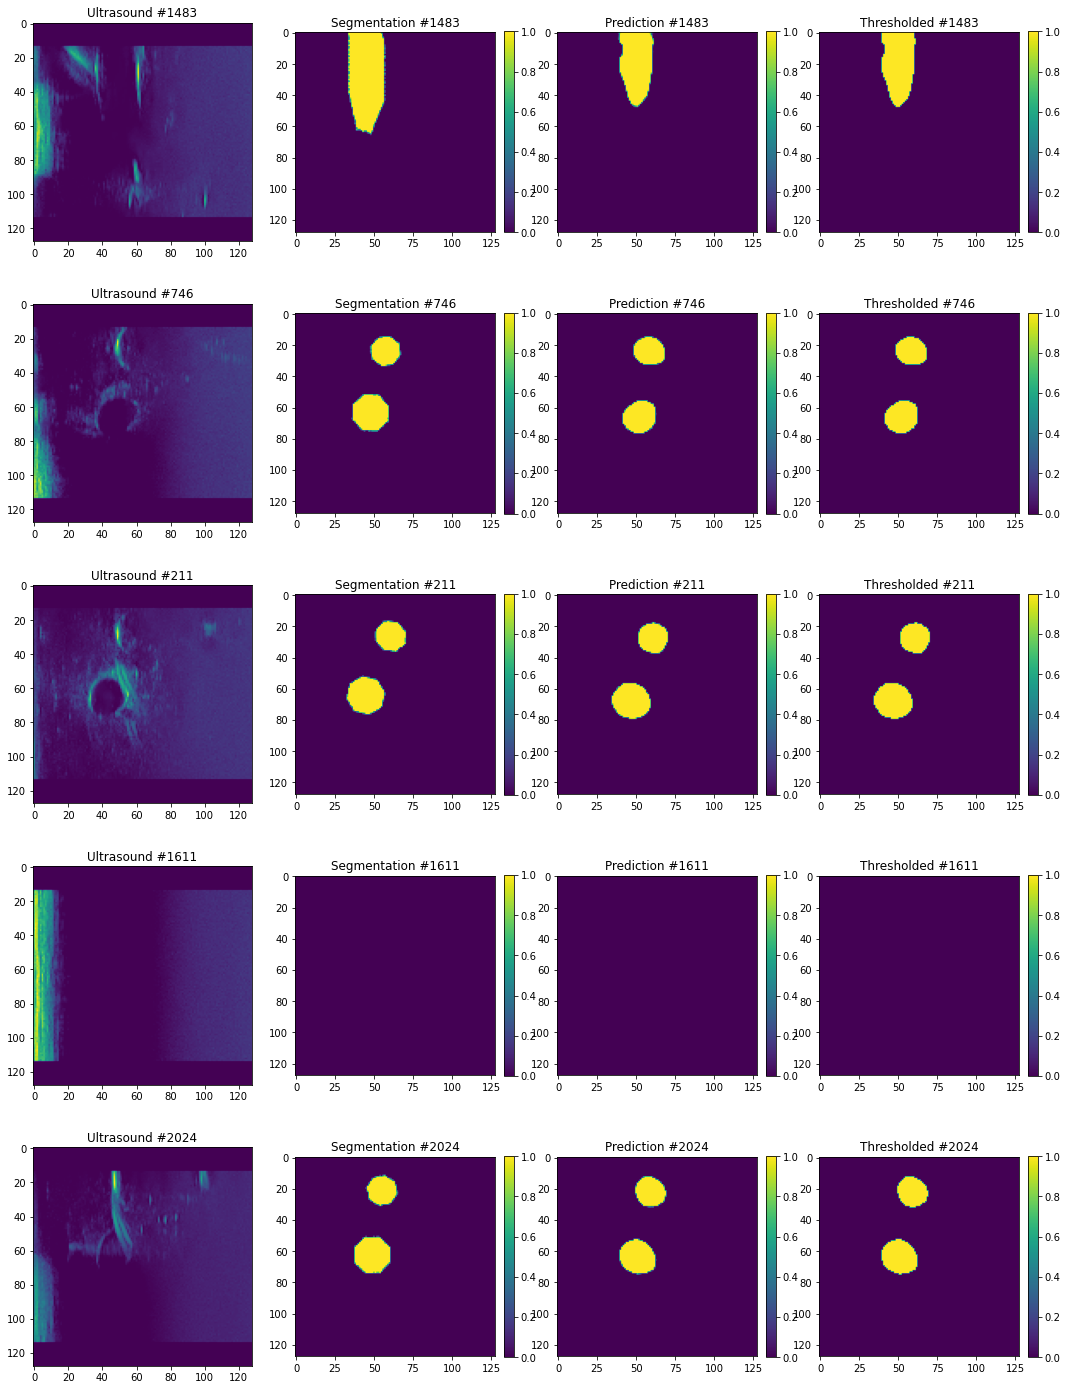

In [59]:
#Set plotting variables
num_show = 5
num_col = 4
num_vali = 2200
threshold = 0.30

#Randomly generate a set of indices to print
indices = [i for i in range(num_vali)]
sample_indices = sample(indices, num_show)

#Print 4 columns of images
fig = plt.figure(figsize=(18, num_show*5))
for i in range(num_show):
    
    #Plot US image
    a0 = fig.add_subplot(num_show, num_col, i*num_col+1)
    img0 = a0.imshow(np.flipud(us_test[sample_indices[i], :, :, 0].astype(np.float32)))
    a0.set_title("Ultrasound #{}".format(sample_indices[i]))
    
    #Plot original segmentations
    a1 = fig.add_subplot(num_show, num_col, i*num_col+2)
    img1 = a1.imshow(np.flipud(seg_test[sample_indices[i], :, :, 0]), vmin=0.0, vmax=1.0)
    a1.set_title("Segmentation #{}".format(sample_indices[i]))
    
    #Plot Predicted segmentations
    c = fig.colorbar(img1, fraction=0.046, pad=0.04)
    a2 = fig.add_subplot(num_show, num_col, i*num_col+3)
    img2 = a2.imshow(np.flipud(y_pred_test[sample_indices[i], :, :, 1]), vmin=0.0, vmax=1.0)
    a2.set_title("Prediction #{}".format(sample_indices[i]))
    
    #Plot thresholded segmentations
    c = fig.colorbar(img2, fraction=0.046, pad=0.04)
    a3 = fig.add_subplot(num_show, num_col, i*num_col+4)
    img3 = a3.imshow((np.flipud(y_pred_test[sample_indices[i], :, :, 1]) > threshold), vmin=0.0, vmax=1.0)
    c = fig.colorbar(img3, fraction=0.046, pad=0.04)
    a3.set_title("Thresholded #{}".format(sample_indices[i]))